# Image Classification with Keras

Build a sequential model from scratch.  Features of this example:
- Batched input, suitable for large sets;
- Data augmentation; 
- Dropout and stride training.

## Input
Paths to directories containing training and validation data.  A `keras.ImageDataGenerator` is used to batch process and load these data, which must be stored according to the docs at https://keras.io/preprocessing/image/:

> **directory**: string, path to the target directory. It should contain one subdirectory per class.


## Workflow
1. Load dependencies.
2. Configure data preprocessing and augmentation.
3. Model design
4. Compile and fit.

## Notes on this Example
The dataset initially has the structure
<pre>
flowers 
 -> daisy
 -> ...
 -> tulip
</pre>
but the required structure is 
<pre>
flowers 
 -> train
     -> daisy
     -> ...
     -> tulip
 -> test
     -> daisy
     -> ...
     -> tulip
</pre>
The script that does this organising looks like 
```python
from pathlib import Path
import shutil
from numpy.random import random

p = Path('.')
(p / 'train').mkdir()
(p / 'valid').mkdir()

validation_split = 0.2

for species in 'daisy dandelion rose sunflower tulip'.split():
	(p / 'train' / species).mkdir()
	(p / 'valid' / species).mkdir()
	for img in (p / species).iterdir():
		if random() < validation_split:
			shutil.copy(str(img), str(p / 'valid' / img))
		else: 
			shutil.copy(str(img), str(p / 'train' / img))
	shutil.rmtree(p / species)
```


In [31]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout

In [37]:
prefix = './data/flowers/'
train_path = prefix + 'train'
valid_path = prefix + 'valid'

def preprocess_image(image):
    """ From docs for ImageDataGenerator:
            function that will be applied on each input. 
            The function will run after the image is resized and augmented. 
            The function should take one argument: one image (Numpy tensor with rank 3), 
            and should output a Numpy tensor with the same shape.
        This example normalizes 8bit RGB."""
    return image / 255

# Data augmentation tidily handled by passing args to this constructor.
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    vertical_flip=False,
    horizontal_flip=True)

train_generator = data_generator.flow_from_directory(train_path)
valid_generator = data_generator.flow_from_directory(valid_path)

Found 3443 images belonging to 5 classes.
Found 880 images belonging to 5 classes.


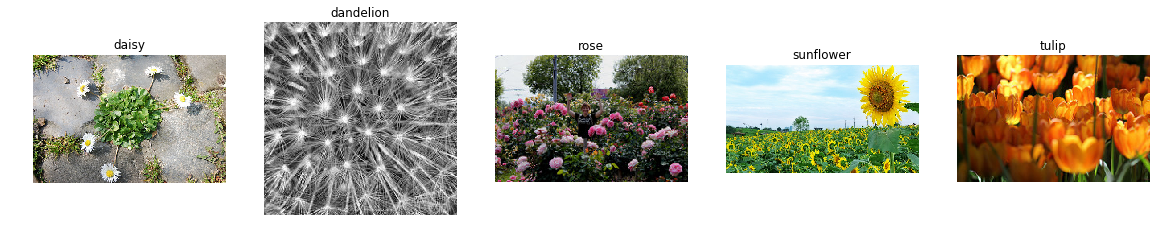

In [90]:
# Nice to see some of the data.
from pathlib import Path
from numpy.random import randint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
labels = []
for species in [x for x in Path(train_path).iterdir() if x.is_dir()]:
    labels.append(species.name)
    species_list = list(species.iterdir())
    image_path = species_list[randint(len(species_list))]
    images.append(mpimg.imread(image_path))

plt.figure(figsize=(20, 10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1, title=labels[i])
    plt.imshow(image)
    plt.axis('off')

In [106]:
model = Sequential()
num_classes = 5

# Input layer.
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu',))

# Hidden layers.
for layer in [
    Conv2D(30, (3, 3), activation='relu', strides=3),
    Dropout(.5),
    Flatten(),
    Dense(128, activation='relu'),]:
    model.add(layer)

# Output layer.
model.add(Dense(units=num_classes, activation='softmax'))

In [107]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(train_generator, epochs=3)

Train for 108 steps
Epoch 1/3
108/108 [==============================] - 61s 562ms/step - loss: 1.6910 - accuracy: 0.3729
Epoch 2/3
108/108 [==============================] - 74s 683ms/step - loss: 1.0939 - accuracy: 0.5635
Epoch 3/3
108/108 [==============================] - 55s 511ms/step - loss: 0.9338 - accuracy: 0.6430


In [96]:
class_labels = 'daisy dandelion rose sunflower tulip'.split()
# extract strongest prediction
y_index = model.predict(valid_generator).argmax(axis=-1)
y = [class_labels[x] for x in y_index]

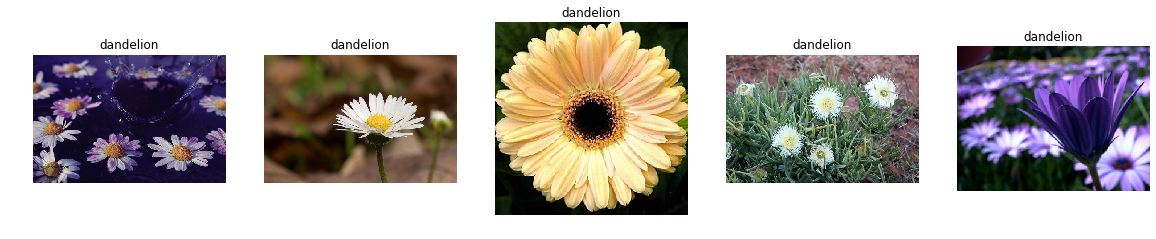

In [105]:
images = [mpimg.imread(x) for x in valid_generator.filepaths[:5]]
labels = y[:5]

fig = plt.figure(figsize=(20, 10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1, title=labels[i])
    plt.imshow(image)
    plt.axis('off')

Apprantly everything is a dandelion.